In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

# Gathering Data

In [7]:
df = pd.read_csv("Tweets.csv")
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.split(n=1).str[1]
df['airline_sentiment'] = df['airline_sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

#75% training/validation 25% testing
train = df[:10980]
test = df[10981:]

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didn't today... must mean i need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Training Datasets

In [8]:
sentences = train['text']
sentences = ["[CLS]" + str(sentence) + "[SEP]" for sentence in sentences]
sentences[:5]

['[CLS]what @dhepburn said.[SEP]',
 "[CLS]plus you've added commercials to the experience... tacky.[SEP]",
 "[CLS]i didn't today... must mean i need to take another trip![SEP]",
 '[CLS]it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse[SEP]',
 "[CLS]and it's a really big bad thing about it[SEP]"]

In [9]:
labels = train['airline_sentiment'].values
labels

array([1, 2, 1, ..., 1, 0, 0])

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS]what @dhepburn said.[SEP]
['[CLS]', 'what', '@', 'dhe', '##p', '##burn', 'said', '.', '[SEP]']


In [11]:
#max length of sequence for input tokens (CAN EDIT FOR BETTER EXPERIMENT) (if we're changing we have to change it for testing dataset below..)
MAX_LEN = 128

#token into number index
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#concat the sentences into max len and fill the empty with 0s
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

input_ids[0]

array([  101, 12976,   137, 11034, 10410, 35497, 12415,   119,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [12]:
#initialization of attention mask
attention_masks = []

#if attention mask is not padding = 1, if padding = 0
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
#getting train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2000, 
                                                                                    test_size=0.1)

#train and validation sets for attention mask
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2000, 
                                                       test_size=0.1)

#change the train and validation sets into tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])                                              

tensor([   101,    177,  10392, 106194,  10115,  14942,  10155,  47808,  10129,
           108,  10854,  28036,  10165,  10477,    106,    106,  11084,  10174,
         13028,    111,  43900,    132,    124,  10556,    131,    120,    120,
           188,    119,  11170,    120,  12541,  11234,  10350,  10575,  10457,
         11011,  10686,    102,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [14]:
#(CAN EDIT FOR BETTER EXPERIMENT) (have to change below for testing set as well)
batch_size = 8

#train the data using pytorch's DataLoader, mask, label as set of datas with batch size of batch_size
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Test dataset

In [15]:
sentences = test['text']
sentences[:5]

10981    why were we loaded onto the plane (4 hours lat...
10982    why load us on the flight if the captain was o...
10983    offloading the plane?!?!?! this is ridiculous!!!!
10984    @jdbwaffles we're excited to have you fly with...
10985    still just sitting here. nobody has said anyth...
Name: text, dtype: object

In [16]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:5]

['[CLS] why were we loaded onto the plane (4 hours late flight, mind you), made to sit for 40 minutes [SEP]',
 '[CLS] why load us on the flight if the captain was over the hours he could fly in one consecutive period? unacceptable. [SEP]',
 '[CLS] offloading the plane?!?!?! this is ridiculous!!!! [SEP]',
 "[CLS] @jdbwaffles we're excited to have you fly with us, jb! when will this be?” spring break !!! [SEP]",
 "[CLS] still just sitting here. nobody has said anything. what's up? [SEP]"]

In [17]:
labels = test['airline_sentiment'].values
labels

array([0, 0, 0, ..., 1, 0, 1])

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


In [19]:
#max length of sequence for input tokens (CAN EDIT FOR BETTER EXPERIMENT) (change training dataset as well..)
MAX_LEN = 128

#token into number index
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#concat the sentences into max len and fill the empty with 0s
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

input_ids[0]

array([   101,  31237,  10309,  11951, 103927,  31095,  10105,  35007,
          113,    125,  19573,  13002,  23578,    117,  21133,  13028,
          114,    117,  11019,  10114,  19285,  10142,  10533,  15304,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [20]:
#initialization of attention mask
attention_masks = []

#if attention mask is not padding = 1, if padding = 0
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,  31237,  10309,  11951, 103927,  31095,  10105,  35007,    113,
           125,  19573,  13002,  23578,    117,  21133,  13028,    114,    117,
         11019,  10114,  19285,  10142,  10533,  15304,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [22]:
#(CAN EDIT FOR BETTER EXPERIMENT) (change in testing dataset as well..)
batch_size = 8

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Modeling

In [23]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.cuda()

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [25]:
# Selecting optimizer for Model, we're using ADAM, could use SGD..  (CAN EDIT FOR BETTER EXPERIMENT) (we have to change it to other optimizer if we want to change)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning rate
                  eps = 1e-8 # epsilon
                )

#(CAN EDIT FOR BETTER EXPERIMENT) (making it bigger might overfit, so make it lower)
epochs = 5

total_steps = len(train_dataloader) * epochs

# setting scheduler for different learning rate (CAN EDIT FOR BETTER EXPERIMENT) (not sure about this one, but we could change num_warmup_stemps)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training the Model

In [26]:
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
torch.cuda.empty_cache()
# so we can check it over with this set seed value
seed_val = 30
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# reset gradient
model.zero_grad()

for epoch_i in range(0, epochs):
    
    print('Epoch: ', epoch_i)
    print('Training...')
    total_loss = 0

    model.train()
        
    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        #forward 
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        #calculating loss 
        loss = outputs[0]

        #calculating total loss
        total_loss += loss.item()

        #back propogation to calculate gradients
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #updating the optimizer
        optimizer.step()

        #decreasing the learning rate using the scheduler
        scheduler.step()

        #reset the gradient
        model.zero_grad()

    #calculating average loss
    avg_train_loss = total_loss / len(train_dataloader)            

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
        
    # ========================================
    #               Validation
    # ========================================

    print("Running Validation...")

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

print("")
print("Training complete!")

Epoch:  0
Training...
  Average training loss: 0.63
Running Validation...
  Accuracy: 0.79
Epoch:  1
Training...
  Average training loss: 0.44
Running Validation...
  Accuracy: 0.83
Epoch:  2
Training...
  Average training loss: 0.33
Running Validation...
  Accuracy: 0.82
Epoch:  3
Training...
  Average training loss: 0.24
Running Validation...
  Accuracy: 0.83
Epoch:  4
Training...
  Average training loss: 0.16
Running Validation...
  Accuracy: 0.83

Training complete!


# Evaluating Testing set

In [28]:
model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

predictions , true_labels = [], []

for step, batch in enumerate(test_dataloader):

    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    predictions.append(logits)
    true_labels.append(label_ids)
print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))


Accuracy: 0.84


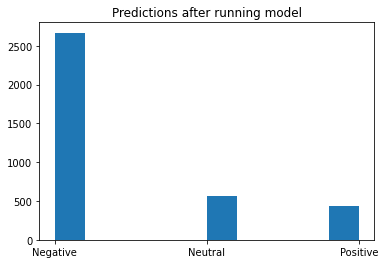

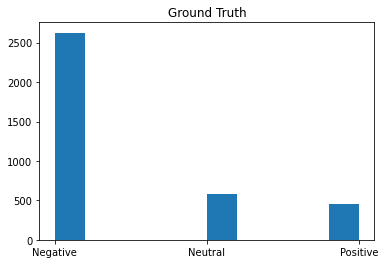

In [29]:
from matplotlib import pyplot as plt

for i in range(len(true_labels)):
  flat_predictions = np.concatenate(predictions, axis=0)

  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  flat_true_labels = np.concatenate(true_labels, axis=0)

pred, true = [], []
for i in range(len(flat_predictions)):
  if flat_predictions[i] == 0:
    pred.append('Negative')
  elif flat_predictions[i] == 1:
    pred.append('Neutral')
  elif flat_predictions[i] == 2:
    pred.append('Positive')

  if flat_true_labels[i] == 0:
    true.append('Negative')
  elif flat_true_labels[i] == 1:
    true.append('Neutral')
  elif flat_true_labels[i] == 2:
    true.append('Positive')
  
plt.hist(pred,)
plt.title('Predictions after running model')
plt.show()
plt.title('Ground Truth')
plt.hist(true,)
plt.show()

In [30]:
print(true.count('Negative'), true.count('Neutral'), true.count('Positive'))
print(pred.count('Negative'), pred.count('Neutral'), pred.count('Positive'))

count = 0
for i in range(len(pred)):
  if pred[i] != true[i]:
    count+=1 

count

2626 577 456
2668 560 431


581

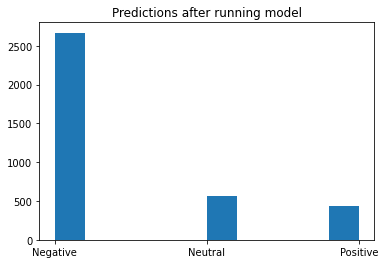

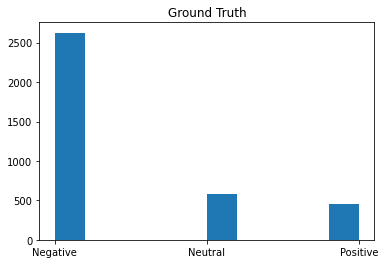

In [31]:
from matplotlib import pyplot as plt

for i in range(len(true_labels)):
  flat_predictions = np.concatenate(predictions, axis=0)

  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  flat_true_labels = np.concatenate(true_labels, axis=0)

pred, true = [], []
for i in range(len(flat_predictions)):
  if flat_predictions[i] == 0:
    pred.append('Negative')
  elif flat_predictions[i] == 1:
    pred.append('Neutral')
  elif flat_predictions[i] == 2:
    pred.append('Positive')

  if flat_true_labels[i] == 0:
    true.append('Negative')
  elif flat_true_labels[i] == 1:
    true.append('Neutral')
  elif flat_true_labels[i] == 2:
    true.append('Positive')
  
plt.hist(pred,)
plt.title('Predictions after running model')
plt.show()
plt.title('Ground Truth')
plt.hist(true,)
plt.show()



        predictions     truth  diff  count
Neg-Neu    Negative   Neutral     0    188
Neu-Neg     Neutral  Negative     0    172
Neg-Pos    Negative  Positive     0     82
Pos-Neg    Positive  Negative     0     56
Pos-Neu    Positive   Neutral     0     42
Neu-Pos     Neutral  Positive     0     41
Neg-Neg    Negative  Negative     1   2398
Neu-Neu     Neutral   Neutral     1    347
Pos-Pos    Positive  Positive     1    333


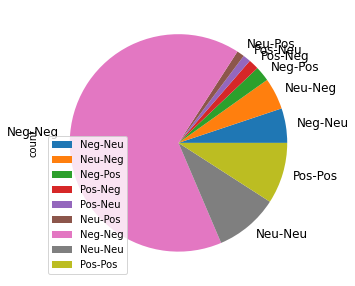

In [226]:
from matplotlib import pyplot as plt

for i in range(len(true_labels)):
  flat_predictions = np.concatenate(predictions, axis=0)

  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  flat_true_labels = np.concatenate(true_labels, axis=0)

pred, true = [], []
for i in range(len(flat_predictions)):
  if flat_predictions[i] == 0:
    pred.append('Negative')
  elif flat_predictions[i] == 1:
    pred.append('Neutral')
  elif flat_predictions[i] == 2:
    pred.append('Positive')

  if flat_true_labels[i] == 0:
    true.append('Negative')
  elif flat_true_labels[i] == 1:
    true.append('Neutral')
  elif flat_true_labels[i] == 2:
    true.append('Positive')
dict = {'predictions': pred, 'truth': true}

#plt.rcParams['figure.figsize'] = [20,10]
"""
new_df['diff'] = ""
for row in new_df.itertuples():
    if (getattr(row, "predictions")== getattr(row, "truth")):
      new_df['diff'] == 0
    else:
      new_df['diff'] == 1
"""
new_df['diff'] = new_df.apply(lambda x: x['predictions'] in x['truth'] , axis=1).astype(int)
diff_class = new_df[new_df['diff']==0].value_counts().reset_index()
#diff_class.reset_index()
diff_class
same_class = new_df[new_df['diff']==1].value_counts().reset_index()
all_class = pd.concat([diff_class,same_class])
all_class.columns = ['predictions', 'truth','diff','count']

all_class.index = ['Neg-Neu', 'Neu-Neg','Neg-Pos', 'Pos-Neg', 'Pos-Neu', 'Neu-Pos', 'Neg-Neg', 'Neu-Neu', 'Pos-Pos']
print(all_class)
all_class.plot.pie(y='count', figsize=(5, 5),fontsize=12)
plt.legend(loc = "lower left")

['Negative', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Ne

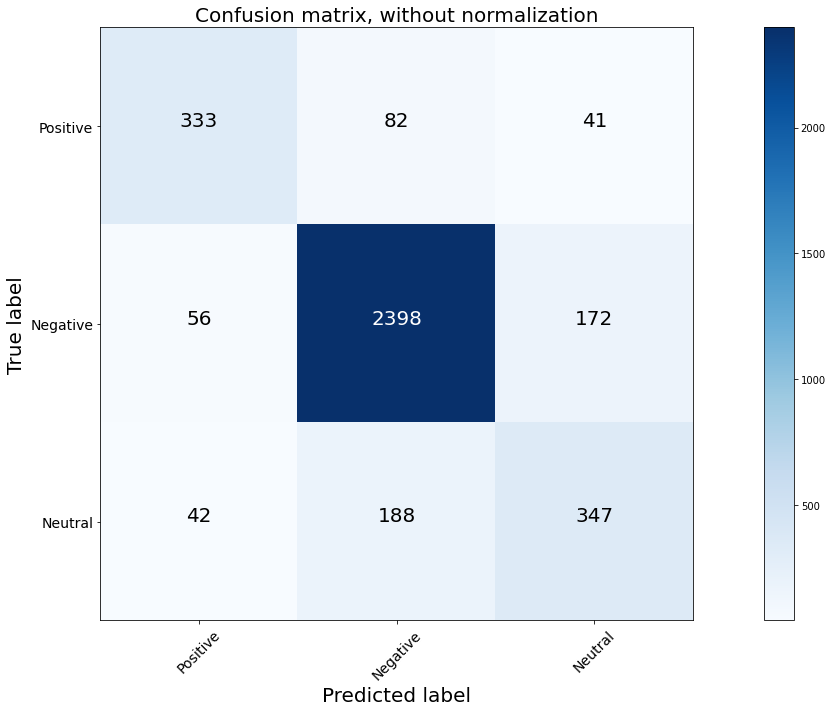

In [211]:
# REf: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=20)

    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

for i in range(len(true_labels)):
  flat_predictions = np.concatenate(predictions, axis=0)

  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  flat_true_labels = np.concatenate(true_labels, axis=0)

pred, true = [], []
for i in range(len(flat_predictions)):
  if flat_predictions[i] == 0:
    pred.append('Negative')
  elif flat_predictions[i] == 1:
    pred.append('Neutral')
  elif flat_predictions[i] == 2:
    pred.append('Positive')

  if flat_true_labels[i] == 0:
    true.append('Negative')
  elif flat_true_labels[i] == 1:
    true.append('Neutral')
  elif flat_true_labels[i] == 2:
    true.append('Positive')

print(true)
cnf_matrix = confusion_matrix(true, pred,labels=['Positive', 'Negative', 'Neutral'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['Positive', 'Negative', 'Neutral'],
                      title='Confusion matrix, without normalization')